In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torchvision.models import ResNet18_Weights

In [3]:
path='images/normal/Ex002000.T000.D000.P000.H000.LA.TIF'
image = cv2.imread(path)

x = np.array(image)
print("Image Shape:", x.shape)
print("Image Data Type:", x.dtype)
print("Min Pixel Value:", x.min())
print("Max Pixel Value:", x.max())

Image Shape: (2488, 3312, 3)
Image Data Type: uint8
Min Pixel Value: 0
Max Pixel Value: 9


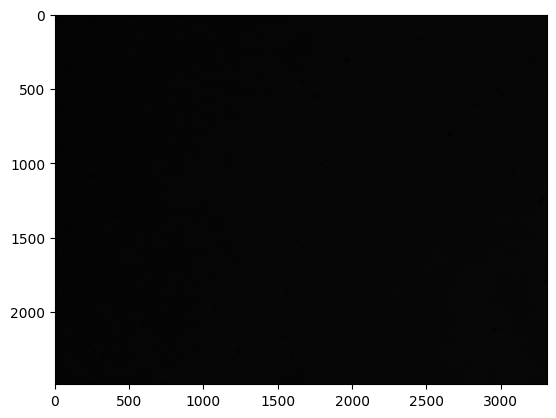

In [4]:
plt.imshow(image)

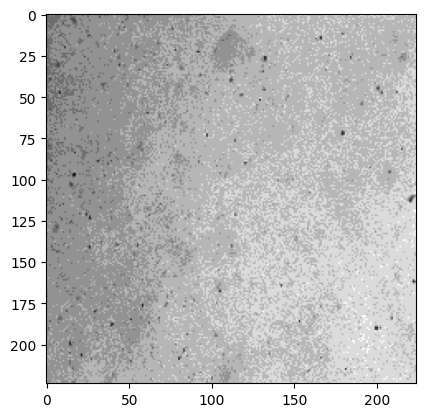

In [5]:
resized_image=cv2.resize(image, (224, 224))
x = cv2.normalize(resized_image, None, 0, 255, cv2.NORM_MINMAX)
plt.imshow(x)

In [6]:
class Load_data(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith(('.TIF'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

In [7]:
class Preprocess:
    def __call__(self, image):
        sample = np.array(image)
        sample = cv2.normalize(sample, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        processed_image = Image.fromarray(sample).convert('RGB')
        return processed_image

Epoch [1/100], Loss: 0.0308
Epoch [2/100], Loss: 0.0308
Epoch [3/100], Loss: 0.0307
Epoch [4/100], Loss: 0.0305
Epoch [5/100], Loss: 0.0303
Epoch [6/100], Loss: 0.0296
Epoch [7/100], Loss: 0.0282
Epoch [8/100], Loss: 0.0251
Epoch [9/100], Loss: 0.0194
Epoch [10/100], Loss: 0.0135
Epoch [11/100], Loss: 0.0187
Epoch [12/100], Loss: 0.0131
Epoch [13/100], Loss: 0.0093
Epoch [14/100], Loss: 0.0100
Epoch [15/100], Loss: 0.0105
Epoch [16/100], Loss: 0.0095
Epoch [17/100], Loss: 0.0079
Epoch [18/100], Loss: 0.0077
Epoch [19/100], Loss: 0.0089
Epoch [20/100], Loss: 0.0078
Epoch [21/100], Loss: 0.0066
Epoch [22/100], Loss: 0.0068
Epoch [23/100], Loss: 0.0070
Epoch [24/100], Loss: 0.0060
Epoch [25/100], Loss: 0.0050
Epoch [26/100], Loss: 0.0057
Epoch [27/100], Loss: 0.0044
Epoch [28/100], Loss: 0.0044
Epoch [29/100], Loss: 0.0046
Epoch [30/100], Loss: 0.0035
Epoch [31/100], Loss: 0.0044
Epoch [32/100], Loss: 0.0032
Epoch [33/100], Loss: 0.0039
Epoch [34/100], Loss: 0.0031
Epoch [35/100], Loss: 0

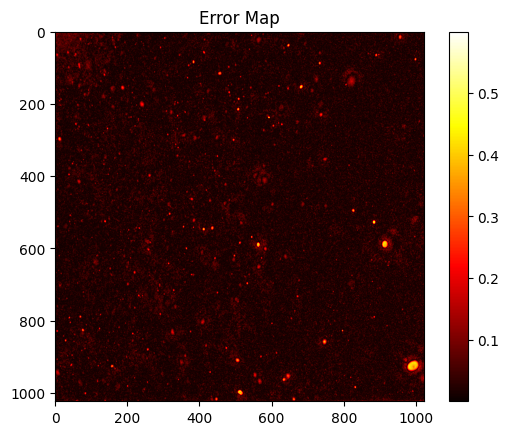

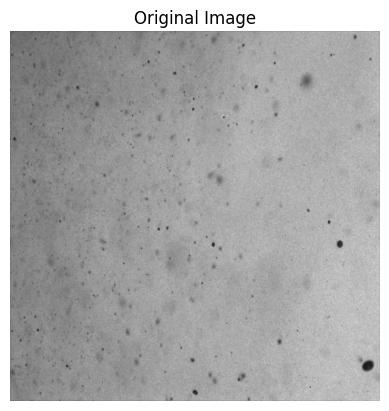

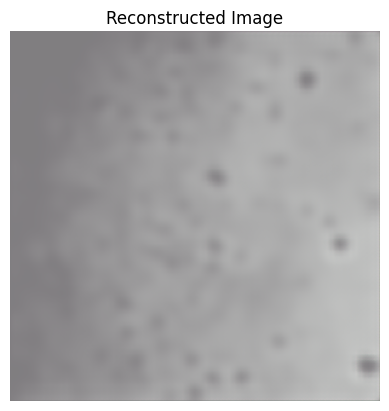

In [8]:
transform = transforms.Compose([
    Preprocess(),
    transforms.Resize((1024,1024)),
    transforms.ToTensor(),
])

dataset = Load_data(root_dir='images/normal', transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

pretrained_encoder = models.vgg16(weights="IMAGENET1K_V1")
encoder = nn.Sequential(*list(pretrained_encoder.features.children())[:-1])

class Autoencoder(nn.Module):
    def __init__(self, encoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 14x14 -> 28x28
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 28x28 -> 56x56
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 56x56 -> 112x112
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),    # 112x112 -> 224x224
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = Autoencoder(encoder).to(device)
autoencoder = nn.DataParallel(autoencoder)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0001)

num_epochs = 100
for epoch in range(num_epochs):
    for img in dataloader:
        img = img.to(device)
        
        # forward pass
        output = autoencoder(img)
        
        loss = criterion(output, img)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


sample_img = next(iter(dataloader))
sample_img = sample_img.to(device)

# forward pass sample_img through our trained model
with torch.no_grad():
    reconstructed_img = autoencoder(sample_img)

reconstructed_img = torch.clamp(reconstructed_img, 0, 1)

error_map = torch.abs(sample_img - reconstructed_img).mean(dim=1).cpu().numpy()
error_map_image = error_map[0] 
plt.imshow(error_map_image, cmap="hot")
plt.colorbar()
plt.title("Error Map")
plt.show()

def display_image(tensor, title="Image"):
    img = tensor.cpu().detach().permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)  # Ensure values are in [0, 1] range
    plt.imshow(img)
    plt.axis("off")
    plt.title(title)
    plt.show()

display_image(sample_img[0], title="Original Image")
display_image(reconstructed_img[0], title="Reconstructed Image")

In [9]:
# Step 1: Convert the image to a PyTorch tensor and add batch dimension
#original_image_tensor = torch.tensor(sample_img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)

# Step 2: Pass the image through the encoder
with torch.no_grad():  # Disable gradient calculations
  reconstructed_image = autoencoder(sample_img)

# Step 3: Flatten the latent space
# Flatten the spatial dimensions
reconstructed_image_flat = reconstructed_image.permute(0, 2, 3, 1).reshape(-1, reconstructed_image.shape[1])

print(f"Flattened reconstructed image shape: {reconstructed_image_flat.shape}")

Flattened reconstructed image shape: torch.Size([11534336, 3])


In [10]:
from sklearn.preprocessing import StandardScaler

# Step 1: Normalize the data
scaler = StandardScaler()
#latent_space_normalized = scaler.fit_transform(latent_space_flat.cpu().numpy())  # Move tensor to CPU before converting to NumPy

reconstructed_image_normalized = scaler.fit_transform(reconstructed_image_flat.cpu())

print(f"Normalized reconstructed image shape: {reconstructed_image_normalized.shape}")

Normalized reconstructed image shape: (11534336, 3)


In [ ]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples as needed
cluster_labels = dbscan.fit_predict(reconstructed_image_normalized)

# Summarize clustering results
num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
num_noise_points = list(cluster_labels).count(-1)

print(f"Number of clusters found: {num_clusters}")
print(f"Number of noise points: {num_noise_points}")

In [ ]:
# Reshape cluster labels back to spatial dimensions
batch_size, height, width = reconstructed_image.shape[0], reconstructed_image.shape[2], reconstructed_image.shape[3]
cluster_image = cluster_labels.reshape(batch_size, height, width)

print(f"Cluster image shape: {cluster_image.shape}")

In [ ]:
import matplotlib.pyplot as plt

# Visualize a single image with clusters
image_index = 0  # Visualize the first image in the batch
plt.figure(figsize=(10, 5))

# Reconstructed image
plt.subplot(1, 2, 1)
plt.imshow(reconstructed_image[image_index].permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.title("Reconstructed Image")
plt.axis("off")

# Clusters
plt.subplot(1, 2, 2)
plt.imshow(cluster_image[image_index].cpu(), cmap="tab20")
plt.title("Clusters on Reconstructed Image")
plt.axis("off")

plt.show()

In [ ]:
from collections import Counter
import numpy as np

# Count occurrences of each cluster label
cluster_counts = Counter(cluster_labels)

# Display counts
for cluster, count in sorted(cluster_counts.items()):
    cluster_name = f"Cluster {cluster}" if cluster != -1 else "Noise"
    print(f"{cluster_name}: {count} points")

# Optional: Convert counts to a NumPy array for further analysis
counts_array = np.array(list(cluster_counts.items()))  # Format: [[cluster_label, count], ...]

In [ ]:
# Fix: Reshape cluster labels for all batches
batch_size = latent_space.shape[0]  # 11
spatial_shape = (latent_space.shape[2], latent_space.shape[3])  # [H, W]
cluster_image = cluster_labels.reshape((batch_size, *spatial_shape))

print("Cluster image shape (batch, H, W):", cluster_image.shape)

# Visualize the first image in the batch
image_index = 0  # Choose which batch to visualize
single_cluster_image = cluster_image[image_index]

# Step 2: Create a color map for visualization
import matplotlib.pyplot as plt
import numpy as np

# Generate random colors for each cluster (noise = gray)
num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
colors = np.random.rand(num_clusters + 1, 3)  # Random colors
colors[-1] = [0.5, 0.5, 0.5]  # Gray for noise

# Create an RGB image for visualization
cluster_visualization = np.zeros((*spatial_shape, 3), dtype=np.float32)
for i in range(spatial_shape[0]):
    for j in range(spatial_shape[1]):
        label = single_cluster_image[i, j]
        cluster_visualization[i, j] = colors[label if label != -1 else -1]

# Fix for original image shape
original_image_to_plot = sample_img[image_index].cpu()

# If the image has 3 channels, transpose it to [H, W, C]
if original_image_to_plot.shape[0] == 3:  # Check if channels-first format
    original_image_to_plot = original_image_to_plot.permute(1, 2, 0)

# If the image is grayscale, select a single channel
if original_image_to_plot.ndim == 3 and original_image_to_plot.shape[-1] == 1:
    original_image_to_plot = original_image_to_plot.squeeze(-1)  # Remove single channel

# Plot the corrected image
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image_to_plot, cmap="gray" if original_image_to_plot.ndim == 2 else None)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title(f"Clusters on Original Image (Batch {image_index})")
plt.imshow(cluster_visualization)
plt.axis("off")
plt.show()

In [ ]:
# Ensure `original_image_copy` is properly formatted
original_image_copy = sample_img[0].cpu().permute(1, 2, 0).numpy()
original_image_copy = (original_image_copy * 255).astype(np.uint8)
original_image_copy = np.ascontiguousarray(original_image_copy)

# If grayscale, convert to BGR
if original_image_copy.ndim == 2 or original_image_copy.shape[2] == 1:
    original_image_copy = cv2.cvtColor(original_image_copy, cv2.COLOR_GRAY2BGR)

# Infer the latent spatial dimensions
latent_height, latent_width = 64, 64  # Adjust based on your model's architecture
scale_y = original_image_copy.shape[0] / latent_height
scale_x = original_image_copy.shape[1] / latent_width

# Reshape the latent space to match the spatial dimensions
latent_space_spatial = latent_space_reduced.reshape(latent_height, latent_width, -1)

# Transform latent space coordinates to image space
latent_to_image_coords = latent_space_reduced[:, :2] * [scale_x, scale_y]  # Use only the first two dimensions

# Updated: Draw circles for each cluster
for cluster_id in set(cluster_labels):
    if cluster_id == -1:  # Skip noise points
        continue

    # Get all points belonging to this cluster
    cluster_points = latent_to_image_coords[cluster_labels == cluster_id]

    # Ensure cluster_points is a NumPy array with shape (N, 2)
    cluster_points = np.array(cluster_points, dtype=np.float32).reshape(-1, 2)

    # Skip clusters with fewer than 3 points
    if cluster_points.shape[0] < 3:
        print(f"Skipping cluster {cluster_id} due to insufficient points.")
        continue

    # Compute the enclosing circle for the cluster
    center, radius = cv2.minEnclosingCircle(cluster_points)

    # Validate and adjust center and radius
    center = tuple(map(int, center))  # Convert center to integers
    center = (max(0, min(center[0], original_image_copy.shape[1] - 1)),
              max(0, min(center[1], original_image_copy.shape[0] - 1)))  # Clamp to valid bounds
    radius = max(1, int(radius))  # Ensure radius is at least 1 pixel

    # Draw the circle on the image
    color = tuple(np.random.randint(0, 255, 3).tolist())  # Random color
    cv2.circle(original_image_copy, center, radius, color, 2)

# Display the final image with circles
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(original_image_copy, cv2.COLOR_BGR2RGB))
plt.title("Clusters with Circles (Correct Dimensions)")
plt.axis("off")
plt.show()